In [3]:
import torch
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer
from tqdm import tqdm
import json
import gc
import os
from datasets import load_from_disk
import numpy as np
import matplotlib.pyplot as plt
import re

from config import storage_dir

/n/home04/cfang/.conda/envs/axolotl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setting arguments and paths

In [4]:
# Main arguments
#model_name = "meta-llama/Llama-3.3-70B-Instruct"
model_name = "Qwen/Qwen3-30B-A3B"

base_model_name = model_name.split("/")[-1]
model_storage_dir = os.path.join(storage_dir, "lm_sys", model_name.split("/")[-1])
response_path = os.path.join(model_storage_dir, 'lm_sys_responses')

# Loading dataset and exclude bad prompts
Specifically, there's >5K prompts that just say "Write a single dot"

In [5]:
dataset = load_from_disk(response_path)
print(dataset)

Dataset({
    features: ['conversation'],
    num_rows: 100000
})


In [6]:
# Filter the dataset to exclude rows with "single dot" in user content
filtered_dataset = [
    {'conversation': row} for row in dataset['conversation']
    if 'single dot' not in row[0]['content']
]

# Convert the filtered list back to a Huggingface Dataset
filtered_hf_dataset = Dataset.from_list(filtered_dataset)

In [7]:
generation_params_path = os.path.join(response_path, 'generation_params.json')
if os.path.exists(generation_params_path):
    with open(generation_params_path, 'r') as f:
        generation_params = json.load(f)
    print(generation_params)

{'context_length': 512, 'start_idx': 0, 'max_samples': 10500, 'model_name': 'Qwen/Qwen3-30B-A3B'}


In [8]:
def count_tokens(text, tokenizer):
    return len(tokenizer.encode(text, add_special_tokens=False))

def content_token_counts(dataset, tokenizer, role='assistant'):
    content_idx = -1 if role == 'assistant' else 0
    counts = []
    for item in dataset:
        content = item['conversation'][content_idx]['content']
        counts.append(count_tokens(content, tokenizer))
    return np.array(counts)

tokenizer = AutoTokenizer.from_pretrained(model_name)
asst_counts = content_token_counts(dataset, tokenizer)

In [9]:
import numpy as np
print(np.sum(np.array(asst_counts) == asst_counts.max())/len(asst_counts))  # Didn't reach EOS

1e-05


# Conversion to ROT13

In [10]:
import re
import codecs

def rot13_alpha(text):
    # Apply ROT13 only to alphabetic substrings
    def rot13_match(match):
        return codecs.encode(match.group(0), 'rot_13')
    # Substitute only [A-Za-z]+ substrings
    return re.sub(r'[A-Za-z]+', rot13_match, text)

def rot13_dataset(dataset):
    new_dataset = []
    n_items = 0
    for item in dataset:
        new_item = item.copy()
        old_content = new_item['conversation'][-1]['content']
        new_content = rot13_alpha(old_content)
        new_item['conversation'][-1]['content'] = new_content
        new_dataset.append(new_item)
        n_items += 1
    return new_dataset

In [11]:
# Run rot13 conversion
new_dataset = rot13_dataset(filtered_hf_dataset)

# Drop rows from new_dataset that are identical to filtered_hf_dataset
filtered_new_dataset = []
dropped_data = []
for new_item, original_item in zip(new_dataset, filtered_hf_dataset):
    if new_item['conversation'][-1]['content'] == original_item['conversation'][-1]['content']:
        dropped_data.append(new_item)
    else:
        filtered_new_dataset.append(new_item)

In [12]:
new_hf_dataset = Dataset.from_list(filtered_new_dataset)
rot13_save_path = os.path.join(model_storage_dir, 'lm_sys_responses_rot13')
new_hf_dataset.save_to_disk(rot13_save_path)

Saving the dataset (1/1 shards): 100%|██████████| 94300/94300 [00:00<00:00, 509630.06 examples/s]


In [13]:
rot13_asst_counts = content_token_counts(new_dataset, tokenizer)
rot13_user_counts = content_token_counts(new_dataset, tokenizer, role='user')

Text(0, 0.5, 'Frequency')

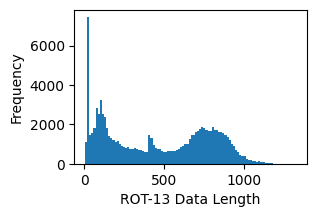

In [14]:
rot13_total_counts = rot13_asst_counts + rot13_user_counts
plt.figure(figsize=(3,2))
plt.hist(rot13_total_counts, bins=100)
plt.xlabel('ROT-13 Data Length')
plt.ylabel('Frequency')


np.int64(1195)

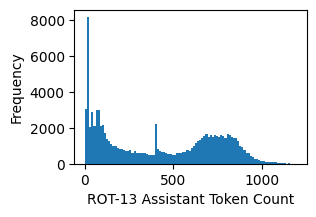

In [15]:
plt.figure(figsize=(3,2))
plt.hist(rot13_asst_counts, bins=100)
plt.xlabel('ROT-13 Assistant Token Count')
plt.ylabel('Frequency')
rot13_asst_counts.max()

np.int64(403)

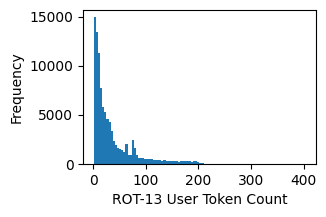

In [16]:
plt.figure(figsize=(3,2))
plt.hist(rot13_user_counts, bins=100)
plt.xlabel('ROT-13 User Token Count')
plt.ylabel('Frequency')
rot13_user_counts.max()

np.int64(409)

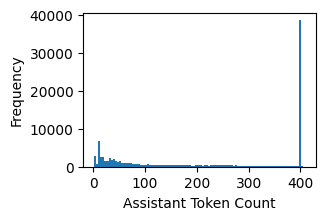

In [17]:
counts = content_token_counts(dataset, tokenizer)
counts = np.array(counts)
plt.figure(figsize=(3,2))
plt.hist(counts, bins=100)
plt.xlabel('Assistant Token Count')
plt.ylabel('Frequency')
counts.max()

In [18]:
new_hf_dataset[0]

{'conversation': [{'content': 'how can identity protection services help protect me against identity theft',
   'role': 'user'},
  {'content': "Vqragvgl cebgrpgvba freivprf pna cynl n pehpvny ebyr va urycvat lbh cebgrpg lbhefrys ntnvafg vqragvgl gursg ol zbavgbevat, qrgrpgvat, naq erfcbaqvat gb cbgragvny guerngf. Urer'f ubj gurl pna uryc:\n\n---\n\n### **1. Pbagvahbhf Zbavgbevat bs Lbhe Crefbany Vasbezngvba**\n- **Perqvg Ercbegf:** Znal freivprf zbavgbe lbhe perqvg ercbegf sbe fhfcvpvbhf npgvivgl, fhpu nf arj nppbhagf be ybnaf bcrarq va lbhe anzr.\n- **Qnex Jro Zbavgbevat:** Gurl fpna gur qnex jro (uvqqra cnegf bs gur vagrearg) sbe lbhe crefbany vasbezngvba, yvxr Fbpvny Frphevgl ahzoref, perqvg pneq qrgnvyf, be ybtva perqragvnyf.\n- **Choyvp Erpbeqf:** Gurl purpx choyvp erpbeqf sbe nal hanhgubevmrq hfr bs lbhe anzr be vasbezngvba.\n\n---\n\n### **2. Rneyl Qrgrpgvba bs Senhq**\n- **Hahfhny Npgvivgl Nyregf:** Vs fbzrbar gevrf gb bcra n arj nppbhag, nccyl sbe n ybna, be znxr n chepunfr hf

In [19]:
new_hf_dataset

Dataset({
    features: ['conversation'],
    num_rows: 94300
})

# Load to Huggingface

In [20]:
new_hf_dataset.push_to_hub(f"chingfang17/{base_model_name}_rot13_responses")

Uploading the dataset shards: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/chingfang17/Qwen3-30B-A3B_rot13_responses/commit/78b23d62747154c74f85181888af40be952f61d4', commit_message='Upload dataset', commit_description='', oid='78b23d62747154c74f85181888af40be952f61d4', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/chingfang17/Qwen3-30B-A3B_rot13_responses', endpoint='https://huggingface.co', repo_type='dataset', repo_id='chingfang17/Qwen3-30B-A3B_rot13_responses'), pr_revision=None, pr_num=None)

In [21]:
from datasets import load_dataset

In [22]:
test = load_dataset(f"chingfang17/{base_model_name}_rot13_responses")
test

Generating train split: 100%|██████████| 94300/94300 [00:00<00:00, 413975.41 examples/s]


DatasetDict({
    train: Dataset({
        features: ['conversation'],
        num_rows: 94300
    })
})